In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
#_optimizer = Adam(0.001, 0.9)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 256, 256, 3), dtype="uint8")
    for i in range(number):
        I = cv2.imread(path + "{:05}_{}.jpeg".format(i+1, train_type))
        I = cv2.resize(I, (0,0), fx=0.5, fy=0.5)
        result[i, :, :, :] = I
    return result

In [3]:
# '''load images, parse test/validation set'''

dataNum = 10000
dataPath = "/home/qian/Downloads/highres_dataset/"
x1 = load_imgs(dataPath, dataNum, 1)
x2 = load_imgs(dataPath, dataNum, 2)
y = load_imgs(dataPath, dataNum, 0)
#y = y[:, 8:-8, 8:-8, :]
mask = load_imgs(dataPath, dataNum, 4)
mask = 255-mask[:, :, :, :1]

x_train1, x_test1, x_train2, x_test2, y_train, y_test, mask_train, mask_test = train_test_split(
    x1, x2, y, mask, test_size=0.20)

In [4]:
# plt.imshow(y[0, :, :, :])
# plt.show()
# print(y.max())
# print(mask.shape)

In [5]:
def encoder_block(x, _filters, _kernel_size, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(x)
    if bn is True:
        y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y

In [6]:
def encoder_net(y):
    y = encoder_block(y, 32, (5, 5), (4, 4), bn = False)
    y = encoder_block(y, 128, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#   y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#     y = layers.Flatten()(y)
#     y = layers.Dense(256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)
    return y

In [7]:
def decoder_block(x, _filters, _kernel_size, _strides, dropout = False):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    if dropout is True:
        y = layers.Dropout(0.5)(y)
    y = layers.ReLU()(y)
    return y

In [8]:
def decoder_net(y):
#     y = layers.Dense(8*8*256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)

#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)imgIdx = 9
# fig=plt.figure(figsize=(12, 12))
# columns = 6
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x_test1[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x_test2[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(mask_test[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
# fig.add_subplot(rows, columns, 5)
# plt.imshow((prediction[imgIdx, :, :, :]+1)/2)
# fig.add_subplot(rows, columns, 6)
# plt.imshow(y_test[imgIdx, :, :, :])
# plt.show()
# # fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))
#     y = layers.Reshape((8, 8, 256))(y)
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2), False)
    y = decoder_block(y, 256, (5, 5), (4, 4), False)
    y = decoder_block(y, 128, (5, 5), (4, 4), False)
    #print(y._keras_shape)
    y = decoder_block(y, 32, (5, 5), (4, 4), False)
    y = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    #y = layers.Softmax(axis = -1)(y)
    return y

In [9]:
def fusionnet(inTensor1, inTensor2):
    out1 = encoder_net(inTensor1)
    out2 = encoder_net(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y

In [10]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
#     # crop the input images to the same size as network output.
#     inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
#     inCrop2 = layers.CroppinimgIdx = 9
# fig=plt.figure(figsize=(12, 12))
# columns = 6
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x_test1[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x_test2[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(mask_test[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
# fig.add_subplot(rows, columns, 5)
# plt.imshow((prediction[imgIdx, :, :, :]+1)/2)
# fig.add_subplot(rows, columns, 6)
# plt.imshow(y_test[imgIdx, :, :, :])
# plt.show()
# # fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))g2D(cropping=((8, 8), (8, 8)))(inTensor2)
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y

In [11]:
img1 = layers.Input(shape=(256, 256, 3))
img2 = layers.Input(shape=(256, 256, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [12]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   2432        input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (R

In [18]:
'''train on generator using MSE of pred & mask.'''
generator.compile(loss=['mse','mse'], loss_weights=[1,0], optimizer= _optimizer)
#generator.fit([x_train1/127.5-1, x_imgIdx = 9

for e in range(10000):
    print("epoch {}:".format(e), end = "")
    rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
    img_batch1 = x_train1[rand_idx, :, :, :].astype('float16')/127.5-1
    img_batch2 = x_train2[rand_idx, :, :, :].astype('float16')/127.5-1
    mask_batch = mask_train[rand_idx, :, :, :].astype('float16')/127.5-1
    y_batch = y_train[rand_idx, :, :, :].astype('float16')/127.5-1
    loss = generator.train_on_batch([img_batch1, img_batch2], [y_batch, mask_batch])
    print(loss[0])

epoch 0:0.010147781
epoch 1:0.00623245
epoch 2:0.009108329
epoch 3:0.008197933
epoch 4:0.009283574
epoch 5:0.0073795766
epoch 6:0.0075871004
epoch 7:0.0051915767
epoch 8:0.003788473
epoch 9:0.0066910195
epoch 10:0.004771726
epoch 11:0.0063648336
epoch 12:0.006390797
epoch 13:0.00933561
epoch 14:0.0054953923
epoch 15:0.008722314
epoch 16:0.005237083
epoch 17:0.0050609247
epoch 18:0.0066577755
epoch 19:0.0074004675
epoch 20:0.01771963
epoch 21:0.010308931
epoch 22:0.0062209177
epoch 23:0.008548908
epoch 24:0.012640154
epoch 25:0.0050919717
epoch 26:0.005762119
epoch 27:0.0035808126
epoch 28:0.0060753888
epoch 29:0.005290238
epoch 30:0.0049252
epoch 31:0.0077848313
epoch 32:0.009191704
epoch 33:0.004864365
epoch 34:0.0035200464
epoch 35:0.008453509
epoch 36:0.0043754596
epoch 37:0.00521008
epoch 38:0.0054910313
epoch 39:0.007388628
epoch 40:0.00591926
epoch 41:0.0154504115
epoch 42:0.007440556
epoch 43:0.007304039
epoch 44:0.0075471057
epoch 45:0.0042893607
epoch 46:0.0064044907
epoch 47:

epoch 371:0.0045945677
epoch 372:0.0034372555
epoch 373:0.003743175
epoch 374:0.005230009
epoch 375:0.004204969
epoch 376:0.0038286643
epoch 377:0.003474941
epoch 378:0.0045547467
epoch 379:0.007703225
epoch 380:0.0055627907
epoch 381:0.0056617795
epoch 382:0.0047469167
epoch 383:0.0044521512
epoch 384:0.007990956
epoch 385:0.0033757328
epoch 386:0.0051841643
epoch 387:0.0047890265
epoch 388:0.00673901
epoch 389:0.0035347566
epoch 390:0.004414331
epoch 391:0.0040201764
epoch 392:0.0038001142
epoch 393:0.004524002
epoch 394:0.007377538
epoch 395:0.004531791
epoch 396:0.0046362216
epoch 397:0.0064048134
epoch 398:0.004342042
epoch 399:0.005511519
epoch 400:0.0033936743
epoch 401:0.0039928863
epoch 402:0.0032885135
epoch 403:0.00668041
epoch 404:0.005551526
epoch 405:0.005680016
epoch 406:0.0037467217
epoch 407:0.0037320536
epoch 408:0.005436545
epoch 409:0.003976772
epoch 410:0.005513165
epoch 411:0.0066511584
epoch 412:0.0070848004
epoch 413:0.004885722
epoch 414:0.005319062
epoch 415:0

epoch 735:0.0024063264
epoch 736:0.005188831
epoch 737:0.00701416
epoch 738:0.004446677
epoch 739:0.0036512953
epoch 740:0.005431062
epoch 741:0.004127253
epoch 742:0.0053502093
epoch 743:0.0037722436
epoch 744:0.0027416567
epoch 745:0.0046922914
epoch 746:0.0029521398
epoch 747:0.0078588575
epoch 748:0.005156624
epoch 749:0.0033474923
epoch 750:0.0032188774
epoch 751:0.0043312134
epoch 752:0.0045350185
epoch 753:0.0050779916
epoch 754:0.0032954512
epoch 755:0.004302528
epoch 756:0.0040480033
epoch 757:0.0032300646
epoch 758:0.0038688555
epoch 759:0.0063624326
epoch 760:0.0050071124
epoch 761:0.0053415494
epoch 762:0.0026515597
epoch 763:0.003870491
epoch 764:0.0029813095
epoch 765:0.0063516316
epoch 766:0.005030483
epoch 767:0.0029315944
epoch 768:0.00564206
epoch 769:0.005073281
epoch 770:0.0042424127
epoch 771:0.0034052932
epoch 772:0.004071381
epoch 773:0.007339009
epoch 774:0.004036866
epoch 775:0.005948986
epoch 776:0.0020374812
epoch 777:0.003828798
epoch 778:0.003637644
epoch 7

epoch 1093:0.003597436
epoch 1094:0.003054277
epoch 1095:0.0038455427
epoch 1096:0.0040677367
epoch 1097:0.0047453367
epoch 1098:0.004150994
epoch 1099:0.0054029156
epoch 1100:0.0026898663
epoch 1101:0.0044425046
epoch 1102:0.005426553
epoch 1103:0.0028845742
epoch 1104:0.0039253454
epoch 1105:0.0025239072
epoch 1106:0.0071420893
epoch 1107:0.003793653
epoch 1108:0.0031472289
epoch 1109:0.002517695
epoch 1110:0.004428791
epoch 1111:0.0064360723
epoch 1112:0.0023628608
epoch 1113:0.0027111038
epoch 1114:0.0036243554
epoch 1115:0.006121208
epoch 1116:0.0029831943
epoch 1117:0.0064301044
epoch 1118:0.00827289
epoch 1119:0.00431236
epoch 1120:0.003008077
epoch 1121:0.0023255427
epoch 1122:0.004509651
epoch 1123:0.005757788
epoch 1124:0.0043363036
epoch 1125:0.0041971267
epoch 1126:0.004670171
epoch 1127:0.004698457
epoch 1128:0.0053171087
epoch 1129:0.0061742878
epoch 1130:0.00424772
epoch 1131:0.0039396533
epoch 1132:0.0052990858
epoch 1133:0.0021430142
epoch 1134:0.00685528
epoch 1135:0.

epoch 1440:0.0026838258
epoch 1441:0.0074741133
epoch 1442:0.0054648756
epoch 1443:0.003004701
epoch 1444:0.007851522
epoch 1445:0.0029605008
epoch 1446:0.005236623
epoch 1447:0.0056302017
epoch 1448:0.0025737444
epoch 1449:0.0026805843
epoch 1450:0.004353209
epoch 1451:0.002677419
epoch 1452:0.0032749814
epoch 1453:0.0023139468
epoch 1454:0.0050946358
epoch 1455:0.0032928167
epoch 1456:0.0040780567
epoch 1457:0.0037835506
epoch 1458:0.0032419635
epoch 1459:0.002603666
epoch 1460:0.004604528
epoch 1461:0.0041090045
epoch 1462:0.00521846
epoch 1463:0.0028667971
epoch 1464:0.0031087329
epoch 1465:0.0045109103
epoch 1466:0.004523458
epoch 1467:0.0028557277
epoch 1468:0.0038412337
epoch 1469:0.0037743512
epoch 1470:0.001831014
epoch 1471:0.0029545026
epoch 1472:0.0039917417
epoch 1473:0.0018770706
epoch 1474:0.0020933477
epoch 1475:0.003934321
epoch 1476:0.004331774
epoch 1477:0.00314898
epoch 1478:0.0053099548
epoch 1479:0.003847331
epoch 1480:0.0022840563
epoch 1481:0.0041758385
epoch 14

epoch 1787:0.0044677877
epoch 1788:0.007305259
epoch 1789:0.003365368
epoch 1790:0.0047978414
epoch 1791:0.0036272209
epoch 1792:0.0040368005
epoch 1793:0.0024313128
epoch 1794:0.008695481
epoch 1795:0.003564778
epoch 1796:0.0036678177
epoch 1797:0.0035634546
epoch 1798:0.0036238157
epoch 1799:0.002079574
epoch 1800:0.004786198
epoch 1801:0.0033248414
epoch 1802:0.0037668874
epoch 1803:0.0037267092
epoch 1804:0.003117556
epoch 1805:0.0020695245
epoch 1806:0.0036748985
epoch 1807:0.004205981
epoch 1808:0.0050154673
epoch 1809:0.0060344078
epoch 1810:0.007141731
epoch 1811:0.0034553846
epoch 1812:0.0047239866
epoch 1813:0.005342138
epoch 1814:0.002403308
epoch 1815:0.005208334
epoch 1816:0.0020723348
epoch 1817:0.00295127
epoch 1818:0.004164695
epoch 1819:0.005437741
epoch 1820:0.0031593586
epoch 1821:0.0049065305
epoch 1822:0.005293727
epoch 1823:0.0029463228
epoch 1824:0.003918462
epoch 1825:0.008782601
epoch 1826:0.003847158
epoch 1827:0.004007212
epoch 1828:0.004737242
epoch 1829:0.0

epoch 2134:0.0073173787
epoch 2135:0.0023637798
epoch 2136:0.006837892
epoch 2137:0.0020769152
epoch 2138:0.003185566
epoch 2139:0.0040183733
epoch 2140:0.00464272
epoch 2141:0.0032888479
epoch 2142:0.005515175
epoch 2143:0.0034861723
epoch 2144:0.0033951276
epoch 2145:0.0034199106
epoch 2146:0.005059166
epoch 2147:0.0036777158
epoch 2148:0.0041671414
epoch 2149:0.0060992017
epoch 2150:0.00337874
epoch 2151:0.0083871605
epoch 2152:0.0034450488
epoch 2153:0.0047412557
epoch 2154:0.0037788039
epoch 2155:0.0028726389
epoch 2156:0.0034905453
epoch 2157:0.0040561673
epoch 2158:0.0063634645
epoch 2159:0.006499395
epoch 2160:0.0037541257
epoch 2161:0.0025838157
epoch 2162:0.004447013
epoch 2163:0.0041404814
epoch 2164:0.0072867363
epoch 2165:0.002409767
epoch 2166:0.0023690364
epoch 2167:0.0076715974
epoch 2168:0.0023340422
epoch 2169:0.004782194
epoch 2170:0.004761283
epoch 2171:0.007855817
epoch 2172:0.005143348
epoch 2173:0.0028315866
epoch 2174:0.0024965159
epoch 2175:0.0025821626
epoch 2

epoch 2481:0.006411898
epoch 2482:0.0039592828
epoch 2483:0.0022517247
epoch 2484:0.00514204
epoch 2485:0.003651557
epoch 2486:0.0039153416
epoch 2487:0.00272519
epoch 2488:0.0067326254
epoch 2489:0.0041023204
epoch 2490:0.0021662149
epoch 2491:0.0022512511
epoch 2492:0.005622179
epoch 2493:0.0032051834
epoch 2494:0.0010818803
epoch 2495:0.002097446
epoch 2496:0.0030969968
epoch 2497:0.0042317277
epoch 2498:0.0055511068
epoch 2499:0.00550047
epoch 2500:0.003849029
epoch 2501:0.0033544987
epoch 2502:0.0037485082
epoch 2503:0.0050168927
epoch 2504:0.0035516913
epoch 2505:0.003985746
epoch 2506:0.0035937855
epoch 2507:0.0025232984
epoch 2508:0.0069689536
epoch 2509:0.006772262
epoch 2510:0.0029495836
epoch 2511:0.006792355
epoch 2512:0.0035235682
epoch 2513:0.0069552353
epoch 2514:0.0043470967
epoch 2515:0.0041677374
epoch 2516:0.0026985505
epoch 2517:0.0031475807
epoch 2518:0.005831754
epoch 2519:0.0070405295
epoch 2520:0.0026307674
epoch 2521:0.005973655
epoch 2522:0.0023310594
epoch 25

epoch 2828:0.0021600907
epoch 2829:0.0023302417
epoch 2830:0.0037939632
epoch 2831:0.0027167199
epoch 2832:0.004806719
epoch 2833:0.003922426
epoch 2834:0.0036790364
epoch 2835:0.0042580785
epoch 2836:0.0033744574
epoch 2837:0.0046604257
epoch 2838:0.0027721445
epoch 2839:0.004133348
epoch 2840:0.0037851555
epoch 2841:0.0059139957
epoch 2842:0.004173166
epoch 2843:0.0026466248
epoch 2844:0.0034122234
epoch 2845:0.0025347932
epoch 2846:0.003077474
epoch 2847:0.003610647
epoch 2848:0.0035660716
epoch 2849:0.0036588646
epoch 2850:0.0030099251
epoch 2851:0.004426747
epoch 2852:0.003590966
epoch 2853:0.006075902
epoch 2854:0.0034306655
epoch 2855:0.007275869
epoch 2856:0.0040563364
epoch 2857:0.0023822836
epoch 2858:0.0058902274
epoch 2859:0.0035138554
epoch 2860:0.0031005759
epoch 2861:0.006617036
epoch 2862:0.0027284448
epoch 2863:0.0039014076
epoch 2864:0.002117707
epoch 2865:0.0057817292
epoch 2866:0.0031563395
epoch 2867:0.0022869254
epoch 2868:0.0033284582
epoch 2869:0.004773389
epoch

epoch 3174:0.0031482317
epoch 3175:0.0019178134
epoch 3176:0.0014853693
epoch 3177:0.0020833947
epoch 3178:0.0013083667
epoch 3179:0.0064169625
epoch 3180:0.005147324
epoch 3181:0.0057155685
epoch 3182:0.0018115479
epoch 3183:0.004651782
epoch 3184:0.0031243605
epoch 3185:0.004501263
epoch 3186:0.0063891127
epoch 3187:0.0043814695
epoch 3188:0.0042941635
epoch 3189:0.0028592278
epoch 3190:0.0033400874
epoch 3191:0.0049498
epoch 3192:0.0035270758
epoch 3193:0.003579487
epoch 3194:0.0036204208
epoch 3195:0.0033783284
epoch 3196:0.0057358705
epoch 3197:0.0032008116
epoch 3198:0.0027674467
epoch 3199:0.0021342714
epoch 3200:0.0047298474
epoch 3201:0.0036554746
epoch 3202:0.004983755
epoch 3203:0.0025420242
epoch 3204:0.004631156
epoch 3205:0.00344603
epoch 3206:0.0031307936
epoch 3207:0.0033503275
epoch 3208:0.0036891317
epoch 3209:0.006255892
epoch 3210:0.00640273
epoch 3211:0.0028988104
epoch 3212:0.006779284
epoch 3213:0.004657294
epoch 3214:0.0038649098
epoch 3215:0.0034430854
epoch 32

epoch 3520:0.0027284538
epoch 3521:0.005582278
epoch 3522:0.003214634
epoch 3523:0.0034768677
epoch 3524:0.0034781431
epoch 3525:0.005003689
epoch 3526:0.0020914315
epoch 3527:0.0043893605
epoch 3528:0.0032339166
epoch 3529:0.0056445026
epoch 3530:0.0009102682
epoch 3531:0.0027728078
epoch 3532:0.0031542573
epoch 3533:0.004105288
epoch 3534:0.0032700445
epoch 3535:0.002248486
epoch 3536:0.0040920563
epoch 3537:0.006498617
epoch 3538:0.0035965368
epoch 3539:0.0036760084
epoch 3540:0.0041555814
epoch 3541:0.0041506058
epoch 3542:0.002962004
epoch 3543:0.0026677297
epoch 3544:0.0031766633
epoch 3545:0.0023193352
epoch 3546:0.0027570953
epoch 3547:0.0010958194
epoch 3548:0.0019622466
epoch 3549:0.0031403268
epoch 3550:0.0031741066
epoch 3551:0.0073199724
epoch 3552:0.0021116755
epoch 3553:0.004420734
epoch 3554:0.007261608
epoch 3555:0.004474097
epoch 3556:0.003631129
epoch 3557:0.002840451
epoch 3558:0.0030060527
epoch 3559:0.0027182861
epoch 3560:0.0026936363
epoch 3561:0.0019034685
epoc

epoch 3866:0.0036833182
epoch 3867:0.005098398
epoch 3868:0.0050412887
epoch 3869:0.0037914398
epoch 3870:0.0026644638
epoch 3871:0.0042853383
epoch 3872:0.0023560442
epoch 3873:0.0074822507
epoch 3874:0.0033226334
epoch 3875:0.003395416
epoch 3876:0.0021932374
epoch 3877:0.004119049
epoch 3878:0.006419069
epoch 3879:0.005019523
epoch 3880:0.0039655906
epoch 3881:0.0019394624
epoch 3882:0.0030175783
epoch 3883:0.0018495154
epoch 3884:0.004477336
epoch 3885:0.004898022
epoch 3886:0.004375576
epoch 3887:0.0059393095
epoch 3888:0.0035070484
epoch 3889:0.0035014767
epoch 3890:0.008215841
epoch 3891:0.004816967
epoch 3892:0.0031635412
epoch 3893:0.003064352
epoch 3894:0.0042702267
epoch 3895:0.0036182941
epoch 3896:0.0025857438
epoch 3897:0.0067091333
epoch 3898:0.0036418722
epoch 3899:0.0037344228
epoch 3900:0.0040386263
epoch 3901:0.0031586287
epoch 3902:0.0029938142
epoch 3903:0.004270802
epoch 3904:0.004252702
epoch 3905:0.0044609015
epoch 3906:0.001844529
epoch 3907:0.0030131135
epoch 

epoch 4213:0.002622998
epoch 4214:0.0024944097
epoch 4215:0.0022410695
epoch 4216:0.0020288948
epoch 4217:0.0048639216
epoch 4218:0.0018407884
epoch 4219:0.0075038606
epoch 4220:0.0040748254
epoch 4221:0.0021601156
epoch 4222:0.0040875617
epoch 4223:0.002010662
epoch 4224:0.0015011141
epoch 4225:0.003059243
epoch 4226:0.0029274933
epoch 4227:0.0047783647
epoch 4228:0.003605904
epoch 4229:0.0023405997
epoch 4230:0.0038458789
epoch 4231:0.0023125848
epoch 4232:0.0019531462
epoch 4233:0.0040784287
epoch 4234:0.003019088
epoch 4235:0.0021936335
epoch 4236:0.0055176746
epoch 4237:0.0055745877
epoch 4238:0.007521161
epoch 4239:0.0027735454
epoch 4240:0.0045283707
epoch 4241:0.0019101076
epoch 4242:0.0046137916
epoch 4243:0.0022589643
epoch 4244:0.0026525294
epoch 4245:0.00691696
epoch 4246:0.002622284
epoch 4247:0.0031961845
epoch 4248:0.0018731043
epoch 4249:0.0040290128
epoch 4250:0.0026035118
epoch 4251:0.0024546767
epoch 4252:0.002426507
epoch 4253:0.006877132
epoch 4254:0.0033442352
epo

epoch 4559:0.0073711067
epoch 4560:0.0028266516
epoch 4561:0.0018641859
epoch 4562:0.002463404
epoch 4563:0.0050169737
epoch 4564:0.0035364013
epoch 4565:0.004808601
epoch 4566:0.0055285874
epoch 4567:0.004961177
epoch 4568:0.0022993642
epoch 4569:0.0034576966
epoch 4570:0.0021351255
epoch 4571:0.0032249016
epoch 4572:0.004156589
epoch 4573:0.003777644
epoch 4574:0.002973923
epoch 4575:0.0029213035
epoch 4576:0.0044405907
epoch 4577:0.0066328216
epoch 4578:0.0022261452
epoch 4579:0.0046472372
epoch 4580:0.002869539
epoch 4581:0.005096376
epoch 4582:0.0022715044
epoch 4583:0.0031465823
epoch 4584:0.002706117
epoch 4585:0.0025313706
epoch 4586:0.003646534
epoch 4587:0.0028616842
epoch 4588:0.002670033
epoch 4589:0.00438055
epoch 4590:0.0021120212
epoch 4591:0.003867146
epoch 4592:0.0031057594
epoch 4593:0.0034260035
epoch 4594:0.0035066872
epoch 4595:0.003366766
epoch 4596:0.0020486186
epoch 4597:0.0037542921
epoch 4598:0.0033068415
epoch 4599:0.0023330138
epoch 4600:0.0024614106
epoch 4

epoch 4905:0.0031093596
epoch 4906:0.0041780244
epoch 4907:0.003266319
epoch 4908:0.0030491762
epoch 4909:0.0028935804
epoch 4910:0.0020123082
epoch 4911:0.0023147885
epoch 4912:0.0031715902
epoch 4913:0.0021050575
epoch 4914:0.0035613119
epoch 4915:0.0046850885
epoch 4916:0.0026750441
epoch 4917:0.0034555176
epoch 4918:0.005234923
epoch 4919:0.0055955225
epoch 4920:0.0033666904
epoch 4921:0.0027706204
epoch 4922:0.0048847813
epoch 4923:0.0018626732
epoch 4924:0.0022358152
epoch 4925:0.0030696727
epoch 4926:0.005172046
epoch 4927:0.0030181245
epoch 4928:0.0040182923
epoch 4929:0.0024534767
epoch 4930:0.0017935695
epoch 4931:0.0027115261
epoch 4932:0.0031906196
epoch 4933:0.005375199
epoch 4934:0.004661532
epoch 4935:0.0045980345
epoch 4936:0.0019446586
epoch 4937:0.003365335
epoch 4938:0.0031272988
epoch 4939:0.002552806
epoch 4940:0.0018909292
epoch 4941:0.00413665
epoch 4942:0.0048276335
epoch 4943:0.003222283
epoch 4944:0.0042603957
epoch 4945:0.0023202538
epoch 4946:0.0039196135
ep

epoch 5251:0.0028935722
epoch 5252:0.0041206563
epoch 5253:0.0012639791
epoch 5254:0.0038668918
epoch 5255:0.0026667682
epoch 5256:0.005624725
epoch 5257:0.0019948853
epoch 5258:0.0025238816
epoch 5259:0.0034889183
epoch 5260:0.004976214
epoch 5261:0.0033805126
epoch 5262:0.0040802723
epoch 5263:0.0033491529
epoch 5264:0.004154982
epoch 5265:0.002250535
epoch 5266:0.0014003775
epoch 5267:0.0038491264
epoch 5268:0.0029079956
epoch 5269:0.0017731749
epoch 5270:0.002864988
epoch 5271:0.0030269786
epoch 5272:0.0035446668
epoch 5273:0.004318449
epoch 5274:0.003527101
epoch 5275:0.0035663485
epoch 5276:0.0025695749
epoch 5277:0.0044426327
epoch 5278:0.006094905
epoch 5279:0.0030214544
epoch 5280:0.0076295305
epoch 5281:0.0013243301
epoch 5282:0.0021873699
epoch 5283:0.002029907
epoch 5284:0.0033013932
epoch 5285:0.0048848647
epoch 5286:0.0034833555
epoch 5287:0.004328682
epoch 5288:0.0027918462
epoch 5289:0.0035761523
epoch 5290:0.0036925315
epoch 5291:0.0026103235
epoch 5292:0.0023127226
ep

epoch 5598:0.004634398
epoch 5599:0.002721625
epoch 5600:0.0037524416
epoch 5601:0.0040395027
epoch 5602:0.0014194094
epoch 5603:0.0032492285
epoch 5604:0.00320276
epoch 5605:0.0061087
epoch 5606:0.0018613499
epoch 5607:0.0038639968
epoch 5608:0.0016635791
epoch 5609:0.003173221
epoch 5610:0.0029738327
epoch 5611:0.004591682
epoch 5612:0.008916773
epoch 5613:0.00636339
epoch 5614:0.0016195601
epoch 5615:0.004802311
epoch 5616:0.004846873
epoch 5617:0.0030240193
epoch 5618:0.0029112026
epoch 5619:0.0022800725
epoch 5620:0.0020881235
epoch 5621:0.0028299456
epoch 5622:0.003566189
epoch 5623:0.0032429765
epoch 5624:0.0027834945
epoch 5625:0.0029438084
epoch 5626:0.0038179238
epoch 5627:0.0028835959
epoch 5628:0.0030653966
epoch 5629:0.0020332981
epoch 5630:0.003007249
epoch 5631:0.0019970683
epoch 5632:0.003987466
epoch 5633:0.0012024357
epoch 5634:0.0024345857
epoch 5635:0.0018697844
epoch 5636:0.0032858022
epoch 5637:0.0046739946
epoch 5638:0.0021770047
epoch 5639:0.0038902843
epoch 564

epoch 5944:0.0050510378
epoch 5945:0.0035416298
epoch 5946:0.0027904285
epoch 5947:0.0025402377
epoch 5948:0.0037445053
epoch 5949:0.002649575
epoch 5950:0.0036622074
epoch 5951:0.001655913
epoch 5952:0.0024936073
epoch 5953:0.0054200273
epoch 5954:0.0037390944
epoch 5955:0.006485587
epoch 5956:0.0034819397
epoch 5957:0.0025205584
epoch 5958:0.0043087685
epoch 5959:0.0013914504
epoch 5960:0.0039057313
epoch 5961:0.0032009901
epoch 5962:0.004470664
epoch 5963:0.0037420942
epoch 5964:0.0043473234
epoch 5965:0.0038476142
epoch 5966:0.0039972505
epoch 5967:0.00289043
epoch 5968:0.0026049917
epoch 5969:0.0019225313
epoch 5970:0.0032699513
epoch 5971:0.0032691432
epoch 5972:0.0029176697
epoch 5973:0.003243817
epoch 5974:0.0038758677
epoch 5975:0.0026664524
epoch 5976:0.004719512
epoch 5977:0.0033044058
epoch 5978:0.0032023245
epoch 5979:0.0039649457
epoch 5980:0.0023616955
epoch 5981:0.0048795575
epoch 5982:0.0040686093
epoch 5983:0.002952593
epoch 5984:0.0016580061
epoch 5985:0.0017842768
e

epoch 6289:0.0032541086
epoch 6290:0.0034944508
epoch 6291:0.004118755
epoch 6292:0.0036560628
epoch 6293:0.0027525942
epoch 6294:0.002104308
epoch 6295:0.002419306
epoch 6296:0.0053069415
epoch 6297:0.0032665625
epoch 6298:0.0049845385
epoch 6299:0.002709439
epoch 6300:0.0029331895
epoch 6301:0.0032509272
epoch 6302:0.0033371411
epoch 6303:0.004853463
epoch 6304:0.0025701658
epoch 6305:0.0027316967
epoch 6306:0.0025689541
epoch 6307:0.0021625743
epoch 6308:0.00344017
epoch 6309:0.0021674691
epoch 6310:0.0032134457
epoch 6311:0.0025225445
epoch 6312:0.0023092781
epoch 6313:0.0051512
epoch 6314:0.0013542139
epoch 6315:0.004567683
epoch 6316:0.0053816224
epoch 6317:0.0027342904
epoch 6318:0.003960969
epoch 6319:0.0033003492
epoch 6320:0.0033633907
epoch 6321:0.005685386
epoch 6322:0.0017659899
epoch 6323:0.0041297507
epoch 6324:0.0031170915
epoch 6325:0.004102231
epoch 6326:0.004252526
epoch 6327:0.00422466
epoch 6328:0.003480093
epoch 6329:0.002565828
epoch 6330:0.0021777335
epoch 6331:

epoch 6635:0.0078672115
epoch 6636:0.0042320318
epoch 6637:0.0043174336
epoch 6638:0.0042571547
epoch 6639:0.0022733374
epoch 6640:0.002780862
epoch 6641:0.0019903302
epoch 6642:0.0029358906
epoch 6643:0.0021006926
epoch 6644:0.0039209127
epoch 6645:0.0026431587
epoch 6646:0.004243512
epoch 6647:0.0068972805
epoch 6648:0.0029918542
epoch 6649:0.005132286
epoch 6650:0.0030997384
epoch 6651:0.0028741157
epoch 6652:0.00295939
epoch 6653:0.004235584
epoch 6654:0.001611982
epoch 6655:0.0030150032
epoch 6656:0.0024064188
epoch 6657:0.0023329963
epoch 6658:0.0030295441
epoch 6659:0.0016743478
epoch 6660:0.0022078315
epoch 6661:0.0027850976
epoch 6662:0.0056659933
epoch 6663:0.0039550024
epoch 6664:0.004256038
epoch 6665:0.0018902149
epoch 6666:0.004642874
epoch 6667:0.0019457892
epoch 6668:0.0039001335
epoch 6669:0.0036380044
epoch 6670:0.004053006
epoch 6671:0.0028982586
epoch 6672:0.0043910462
epoch 6673:0.004304442
epoch 6674:0.0016736719
epoch 6675:0.0033739314
epoch 6676:0.0036802834
epo

epoch 6981:0.003089592
epoch 6982:0.0017225205
epoch 6983:0.002692385
epoch 6984:0.0022824972
epoch 6985:0.0024516769
epoch 6986:0.004304993
epoch 6987:0.0043334863
epoch 6988:0.0032065643
epoch 6989:0.002652519
epoch 6990:0.0056296615
epoch 6991:0.0015473037
epoch 6992:0.0052011944
epoch 6993:0.0022271613
epoch 6994:0.0030829988
epoch 6995:0.0036033103
epoch 6996:0.0017986478
epoch 6997:0.004867739
epoch 6998:0.0017930875
epoch 6999:0.004146749
epoch 7000:0.003795322
epoch 7001:0.0034453915
epoch 7002:0.0055552553
epoch 7003:0.0024544373
epoch 7004:0.0042130016
epoch 7005:0.0024373694
epoch 7006:0.0022466183
epoch 7007:0.0024946292
epoch 7008:0.0032863608
epoch 7009:0.0020165143
epoch 7010:0.0029201007
epoch 7011:0.0028656893
epoch 7012:0.003005139
epoch 7013:0.0029433388
epoch 7014:0.0030485948
epoch 7015:0.0031091874
epoch 7016:0.0026298235
epoch 7017:0.0030206556
epoch 7018:0.0035189101
epoch 7019:0.0024314842
epoch 7020:0.0036574085
epoch 7021:0.0041424595
epoch 7022:0.0030779245


epoch 7326:0.003339477
epoch 7327:0.0028509526
epoch 7328:0.0019112728
epoch 7329:0.0031489292
epoch 7330:0.002714355
epoch 7331:0.009366307
epoch 7332:0.0031631528
epoch 7333:0.0025879557
epoch 7334:0.0048993095
epoch 7335:0.0044929907
epoch 7336:0.0023877954
epoch 7337:0.0029806988
epoch 7338:0.00382933
epoch 7339:0.001466969
epoch 7340:0.0017665628
epoch 7341:0.0037802598
epoch 7342:0.0020940073
epoch 7343:0.0015789545
epoch 7344:0.0036036172
epoch 7345:0.0035470163
epoch 7346:0.002433884
epoch 7347:0.0051442822
epoch 7348:0.0021806979
epoch 7349:0.0029151866
epoch 7350:0.0047173966
epoch 7351:0.003587946
epoch 7352:0.0024309591
epoch 7353:0.003313286
epoch 7354:0.003638736
epoch 7355:0.0019091597
epoch 7356:0.0034662534
epoch 7357:0.0033935169
epoch 7358:0.002892097
epoch 7359:0.0024987196
epoch 7360:0.0034933754
epoch 7361:0.00432914
epoch 7362:0.009099856
epoch 7363:0.004761236
epoch 7364:0.0013007203
epoch 7365:0.003592053
epoch 7366:0.0019216868
epoch 7367:0.0023375582
epoch 73

epoch 7673:0.0035938122
epoch 7674:0.004285007
epoch 7675:0.0027446877
epoch 7676:0.0020176875
epoch 7677:0.002515425
epoch 7678:0.0020447345
epoch 7679:0.003141669
epoch 7680:0.0030273977
epoch 7681:0.0015149522
epoch 7682:0.004192021
epoch 7683:0.0026149726
epoch 7684:0.0025413702
epoch 7685:0.006133002
epoch 7686:0.002640824
epoch 7687:0.0016907951
epoch 7688:0.0026209462
epoch 7689:0.0040118163
epoch 7690:0.0019584682
epoch 7691:0.0035497406
epoch 7692:0.0029425113
epoch 7693:0.0033159885
epoch 7694:0.0019972683
epoch 7695:0.0024702498
epoch 7696:0.0025298665
epoch 7697:0.0042369836
epoch 7698:0.0014380123
epoch 7699:0.0049134744
epoch 7700:0.001214766
epoch 7701:0.0015291367
epoch 7702:0.003997099
epoch 7703:0.0031417557
epoch 7704:0.0058449497
epoch 7705:0.0039975974
epoch 7706:0.0027338197
epoch 7707:0.002117734
epoch 7708:0.0022021253
epoch 7709:0.004133824
epoch 7710:0.003646069
epoch 7711:0.0048490623
epoch 7712:0.004501085
epoch 7713:0.0028886893
epoch 7714:0.0039419495
epoc

epoch 8019:0.005789887
epoch 8020:0.0025094328
epoch 8021:0.0025893427
epoch 8022:0.003105487
epoch 8023:0.006349452
epoch 8024:0.0031591598
epoch 8025:0.006059486
epoch 8026:0.00267478
epoch 8027:0.0032138475
epoch 8028:0.002844366
epoch 8029:0.0033294163
epoch 8030:0.003382153
epoch 8031:0.0013024618
epoch 8032:0.0029244493
epoch 8033:0.0026627108
epoch 8034:0.001804238
epoch 8035:0.0016987199
epoch 8036:0.0013090085
epoch 8037:0.0016928238
epoch 8038:0.0029051467
epoch 8039:0.0034270335
epoch 8040:0.0038066816
epoch 8041:0.0013843463
epoch 8042:0.0027252783
epoch 8043:0.0043139094
epoch 8044:0.0028619177
epoch 8045:0.002100027
epoch 8046:0.0024422077
epoch 8047:0.0046809404
epoch 8048:0.004461024
epoch 8049:0.0042194556
epoch 8050:0.0037683211
epoch 8051:0.0025592626
epoch 8052:0.0020498359
epoch 8053:0.0024281004
epoch 8054:0.002283717
epoch 8055:0.0047770217
epoch 8056:0.004786792
epoch 8057:0.0035564345
epoch 8058:0.0019318566
epoch 8059:0.0024838422
epoch 8060:0.0036207102
epoch

epoch 8365:0.0020296718
epoch 8366:0.005161536
epoch 8367:0.004094747
epoch 8368:0.0026069852
epoch 8369:0.0051149987
epoch 8370:0.0048087486
epoch 8371:0.0033658573
epoch 8372:0.0040513687
epoch 8373:0.0017794531
epoch 8374:0.002080174
epoch 8375:0.004050647
epoch 8376:0.0030608568
epoch 8377:0.004363601
epoch 8378:0.0035075601
epoch 8379:0.0035862194
epoch 8380:0.004818999
epoch 8381:0.0019531935
epoch 8382:0.0051633315
epoch 8383:0.0033757396
epoch 8384:0.0023795743
epoch 8385:0.0036255256
epoch 8386:0.0041154427
epoch 8387:0.0036097907
epoch 8388:0.0022000747
epoch 8389:0.0033535394
epoch 8390:0.0018323679
epoch 8391:0.0030607102
epoch 8392:0.0039476836
epoch 8393:0.0031302678
epoch 8394:0.0039119204
epoch 8395:0.003477133
epoch 8396:0.0022762758
epoch 8397:0.0022323327
epoch 8398:0.0049245562
epoch 8399:0.0052019204
epoch 8400:0.0025543477
epoch 8401:0.0023458395
epoch 8402:0.0018937978
epoch 8403:0.0028263647
epoch 8404:0.0031836461
epoch 8405:0.005405004
epoch 8406:0.002757638
e

epoch 8710:0.006778481
epoch 8711:0.005977971
epoch 8712:0.0027903712
epoch 8713:0.0033572093
epoch 8714:0.0035238597
epoch 8715:0.0024799542
epoch 8716:0.0029942417
epoch 8717:0.0027260366
epoch 8718:0.0031819437
epoch 8719:0.0023974515
epoch 8720:0.0018684802
epoch 8721:0.0021326835
epoch 8722:0.005207015
epoch 8723:0.0026285343
epoch 8724:0.004474979
epoch 8725:0.0021583608
epoch 8726:0.0028540208
epoch 8727:0.004573198
epoch 8728:0.0034419904
epoch 8729:0.0033576796
epoch 8730:0.003092476
epoch 8731:0.001564218
epoch 8732:0.0036292025
epoch 8733:0.002612566
epoch 8734:0.0036757775
epoch 8735:0.0027720653
epoch 8736:0.0019060554
epoch 8737:0.0028241593
epoch 8738:0.0026899648
epoch 8739:0.004983438
epoch 8740:0.003071938
epoch 8741:0.004295702
epoch 8742:0.003684125
epoch 8743:0.0034101645
epoch 8744:0.0042583365
epoch 8745:0.0038835555
epoch 8746:0.0018705647
epoch 8747:0.00503439
epoch 8748:0.0026847718
epoch 8749:0.0030766097
epoch 8750:0.003408698
epoch 8751:0.0022856086
epoch 8

epoch 9057:0.0049980343
epoch 9058:0.0017953464
epoch 9059:0.0025187824
epoch 9060:0.0038961952
epoch 9061:0.0021363036
epoch 9062:0.0025696792
epoch 9063:0.0044311024
epoch 9064:0.004912143
epoch 9065:0.0049723815
epoch 9066:0.00274652
epoch 9067:0.0014420318
epoch 9068:0.0031339116
epoch 9069:0.0024465134
epoch 9070:0.0017821563
epoch 9071:0.0046535945
epoch 9072:0.0033752979
epoch 9073:0.008096691
epoch 9074:0.0053744926
epoch 9075:0.0025545866
epoch 9076:0.0028548182
epoch 9077:0.0017666228
epoch 9078:0.0061384286
epoch 9079:0.0028236674
epoch 9080:0.0029397612
epoch 9081:0.0021368177
epoch 9082:0.002939049
epoch 9083:0.001889911
epoch 9084:0.0024045021
epoch 9085:0.0037726392
epoch 9086:0.0021810757
epoch 9087:0.0040835636
epoch 9088:0.0043146675
epoch 9089:0.0017744831
epoch 9090:0.0037623658
epoch 9091:0.0026484523
epoch 9092:0.0045004585
epoch 9093:0.007669221
epoch 9094:0.0025040905
epoch 9095:0.0033149514
epoch 9096:0.002800942
epoch 9097:0.002771207
epoch 9098:0.0025592444
e

epoch 9403:0.0025640733
epoch 9404:0.0020439036
epoch 9405:0.0044605415
epoch 9406:0.0017029358
epoch 9407:0.0041750004
epoch 9408:0.003707107
epoch 9409:0.0029100757
epoch 9410:0.0055716448
epoch 9411:0.0024751883
epoch 9412:0.0013772661
epoch 9413:0.0022379817
epoch 9414:0.005899394
epoch 9415:0.0027320962
epoch 9416:0.0018316659
epoch 9417:0.00658065
epoch 9418:0.003634288
epoch 9419:0.0021698205
epoch 9420:0.0017539097
epoch 9421:0.0031750263
epoch 9422:0.0022020624
epoch 9423:0.002861884
epoch 9424:0.003963978
epoch 9425:0.0056123994
epoch 9426:0.0043685036
epoch 9427:0.0033473172
epoch 9428:0.00563006
epoch 9429:0.0017306786
epoch 9430:0.002188732
epoch 9431:0.003169419
epoch 9432:0.0034136253
epoch 9433:0.0023780833
epoch 9434:0.0043603126
epoch 9435:0.0021971595
epoch 9436:0.0014138585
epoch 9437:0.0018497553
epoch 9438:0.0029471084
epoch 9439:0.00358916
epoch 9440:0.0029573264
epoch 9441:0.0019435551
epoch 9442:0.0022367577
epoch 9443:0.0028761413
epoch 9444:0.00406079
epoch 9

epoch 9749:0.0022816043
epoch 9750:0.0038564983
epoch 9751:0.0030773664
epoch 9752:0.00258388
epoch 9753:0.00572647
epoch 9754:0.0038626883
epoch 9755:0.0028060167
epoch 9756:0.0025598085
epoch 9757:0.003212071
epoch 9758:0.003065244
epoch 9759:0.003420291
epoch 9760:0.004725154
epoch 9761:0.003708654
epoch 9762:0.0026010214
epoch 9763:0.0059939213
epoch 9764:0.0045674043
epoch 9765:0.002928844
epoch 9766:0.004141406
epoch 9767:0.0042967275
epoch 9768:0.0015666841
epoch 9769:0.004215462
epoch 9770:0.002035848
epoch 9771:0.0029533508
epoch 9772:0.0051072096
epoch 9773:0.0030086837
epoch 9774:0.0017855334
epoch 9775:0.0049222475
epoch 9776:0.0045651435
epoch 9777:0.0021672677
epoch 9778:0.0041053104
epoch 9779:0.0018041215
epoch 9780:0.00304859
epoch 9781:0.009594346
epoch 9782:0.0027152644
epoch 9783:0.0037414215
epoch 9784:0.0029340712
epoch 9785:0.0029363236
epoch 9786:0.0014624319
epoch 9787:0.002805191
epoch 9788:0.001943559
epoch 9789:0.002933525
epoch 9790:0.00255565
epoch 9791:0.

In [19]:
generator.save('my_model.h5') 

In [26]:
prediction, a= generator.predict([x_test1[:25, :, :, :]/127.5-1, x_test2[:25, :, :, :]/127.5-1])
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_test1[:25, :, :, :]/127.5-1, x_test2[:25, :, :, :]/127.5-1])[0])
#print(prediction.max())

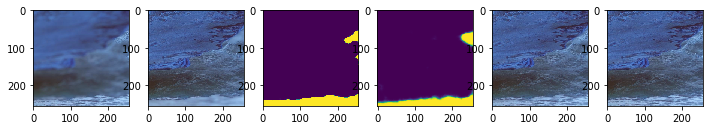

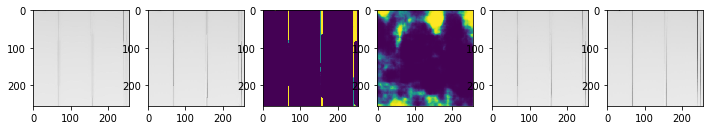

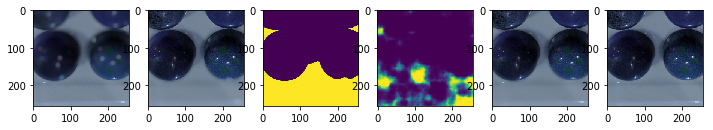

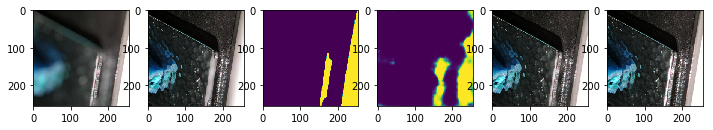

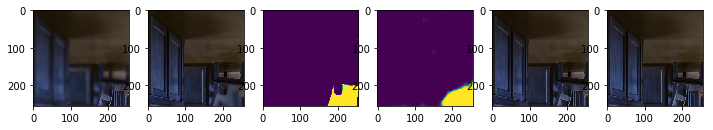

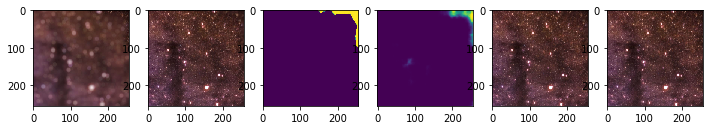

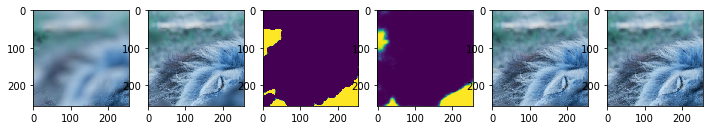

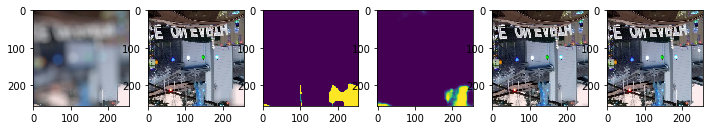

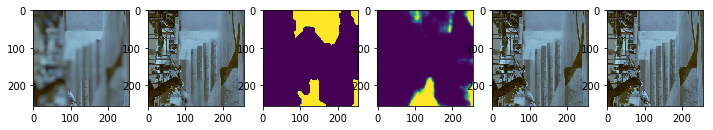

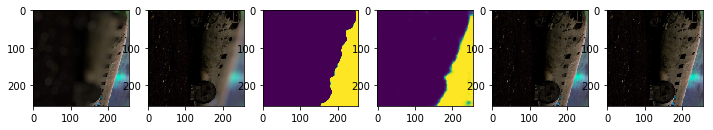

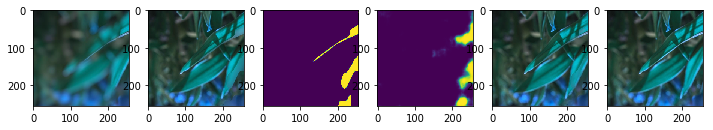

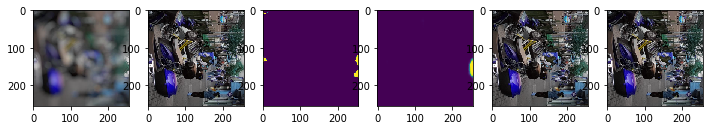

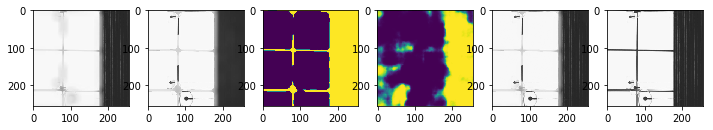

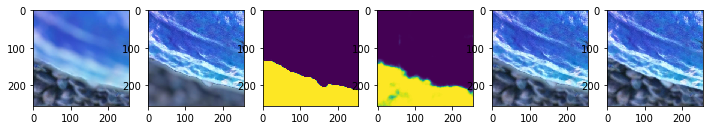

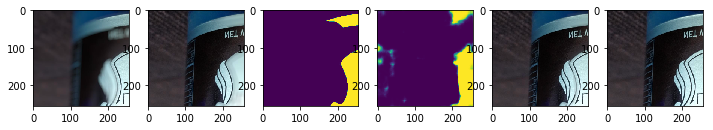

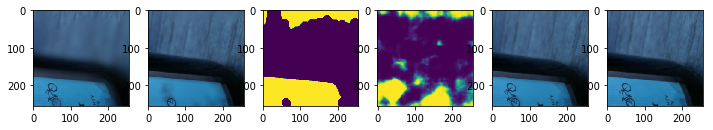

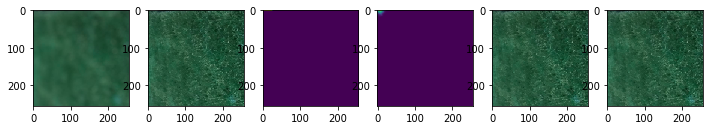

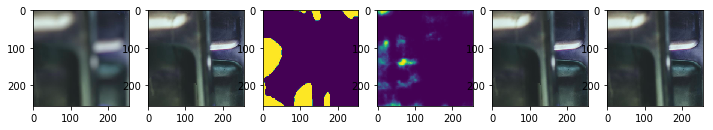

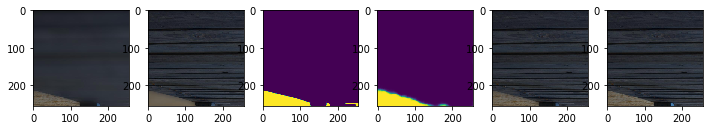

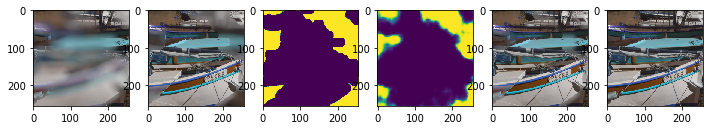

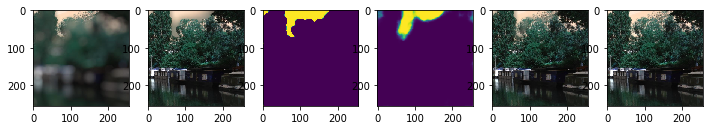

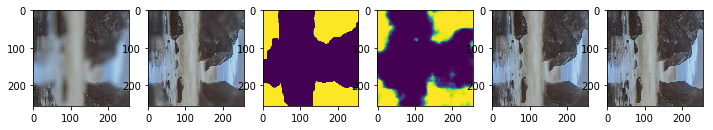

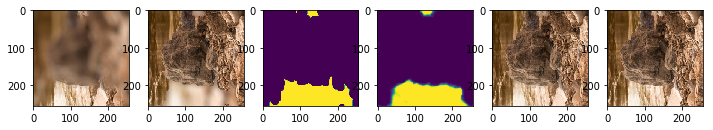

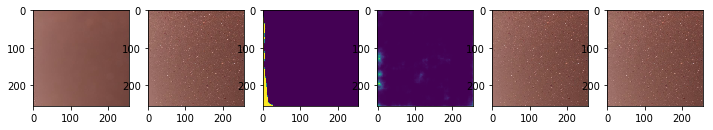

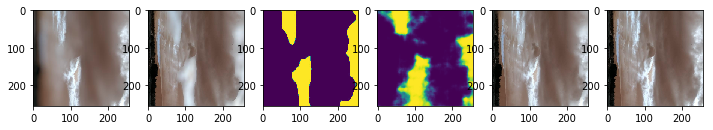

In [27]:
for imgIdx in range(25):
    fig=plt.figure(figsize=(12, 12))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x_test1[imgIdx, :, :, :])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(x_test2[imgIdx, :, :, :])
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask_test[imgIdx, :, :, 0])
    fig.add_subplot(rows, columns, 4)
    plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
    fig.add_subplot(rows, columns, 5)
    plt.imshow((prediction[imgIdx, :, :, :]+1)/2)
    fig.add_subplot(rows, columns, 6)
    plt.imshow(y_test[imgIdx, :, :, :])
    plt.show()
# fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))